In [1]:
import pandas as pd
df = pd.read_csv('c:/data/spam/spam.csv',encoding='latin1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
#ham => 0, spam => 1로 변경
df['v1'] = df['v1'].replace(['ham', 'spam'], [0, 1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

0    4825
1     747
Name: v1, dtype: int64


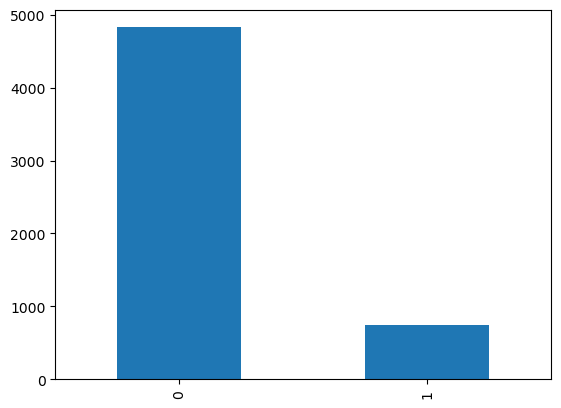

In [4]:
import matplotlib.pyplot as plt
print(df['v1'].value_counts())
df['v1'].value_counts().plot(kind='bar')
plt.show()

In [5]:
X = df[['v2']]
y = df['v1']
print(X.head(3))
print(y.head(3))

                                                  v2
0  Go until jurong point, crazy.. Available only ...
1                      Ok lar... Joking wif u oni...
2  Free entry in 2 a wkly comp to win FA Cup fina...
0    0
1    0
2    1
Name: v1, dtype: int64


In [6]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample, columns=['v2'])
y_samp = pd.DataFrame(data=y_sample, columns=['v1'])
df_samp = pd.concat([X_samp, y_samp], axis=1)
df_samp['v1'].value_counts()

0    747
1    747
Name: v1, dtype: int64

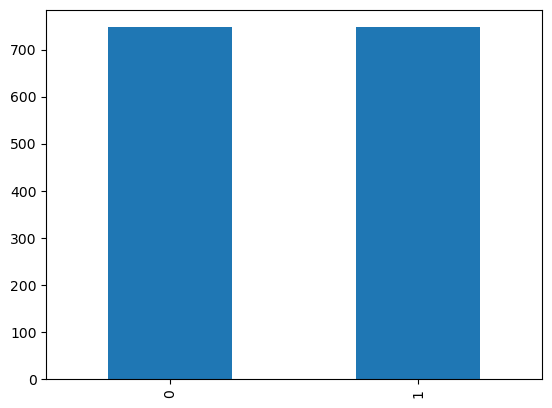

In [7]:
df_samp['v1'].value_counts().plot(kind='bar')
plt.show()

In [8]:
X = df_samp['v2']
y = df_samp['v1']

In [9]:
#단어 집합 생성
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [10]:
#텍스트를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(X)
sequences[:5]

[[1486, 49, 801, 1487, 18, 336, 87, 26, 2274, 45, 27, 173],
 [1148, 14, 4, 25, 613],
 [174, 149, 4, 2, 189, 5, 105, 17, 614, 613],
 [946,
  88,
  38,
  399,
  702,
  1,
  2275,
  1488,
  130,
  2276,
  26,
  1489,
  242,
  45,
  702,
  1,
  2277,
  2278,
  24,
  46,
  1149],
 [7,
  291,
  1490,
  802,
  553,
  53,
  316,
  26,
  803,
  703,
  25,
  63,
  47,
  217,
  1491,
  13,
  434,
  337,
  97]]

In [11]:
#단어와 인덱스 목록
word_to_index = tokenizer.word_index
#word_to_index
for idx,word in enumerate(word_to_index):
    print(idx+1,word, end=',')
    if idx>8:
        break 

1 to,2 you,3 a,4 call,5 i,6 the,7 u,8 your,9 for,10 is,

메일의 최대 길이: 77
메일의 평균 길이: 19.846050870147256


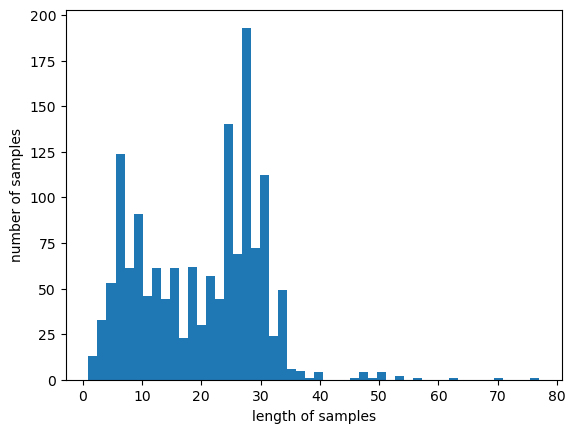

In [12]:
X_data = sequences
print('메일의 최대 길이: %d' % max(len(l) for l in X_data))
print('메일의 평균 길이:', sum(map(len, X_data)) / len(X_data))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pad_sequences(X_data, maxlen=77)
print('학습용 데이터의 크기(shape):', data.shape)
print(data[:1])

학습용 데이터의 크기(shape): (1494, 77)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1486   49  801 1487   18
   336   87   26 2274   45   27  173]]


In [14]:
#학습용:검증용 8:2로 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, 
                                                    stratify=y, random_state=10)

In [15]:
#모델 생성 - SimpleRNN
from keras.layers import Embedding, Dense, SimpleRNN
from keras.models import Sequential
model = Sequential()
# Embedding(입력사이즈,출력사이즈)
model.add(Embedding(len(word_to_index)+1, 32))
model.add(SimpleRNN(32)) # output size 32
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
#모델 학습
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 3s 114ms/step - loss: 0.5658 - accuracy: 0.7385 - val_loss: 0.4688 - val_accuracy: 0.8243
Epoch 2/10
15/15 [==============================] - 2s 101ms/step - loss: 0.3745 - accuracy: 0.8452 - val_loss: 0.3239 - val_accuracy: 0.8870
Epoch 3/10
15/15 [==============================] - 1s 101ms/step - loss: 0.2288 - accuracy: 0.9351 - val_loss: 0.2374 - val_accuracy: 0.9247
Epoch 4/10
15/15 [==============================] - 1s 98ms/step - loss: 0.1441 - accuracy: 0.9644 - val_loss: 0.1681 - val_accuracy: 0.9456
Epoch 5/10
15/15 [==============================] - 2s 102ms/step - loss: 0.1041 - accuracy: 0.9759 - val_loss: 0.2321 - val_accuracy: 0.9205
Epoch 6/10
15/15 [==============================] - 1s 97ms/step - loss: 0.0768 - accuracy: 0.9801 - val_loss: 0.1614 - val_accuracy: 0.9456
Epoch 7/10
15/15 [==============================] - 2s 104ms/step - loss: 0.0678 - accuracy: 0.9833 - val_loss: 0.1292 - val_accuracy: 0.9582
Epoch 8/

In [17]:
#모델평가
model.evaluate(X_test, y_test, verbose=0)

[0.12886160612106323, 0.9598662257194519]

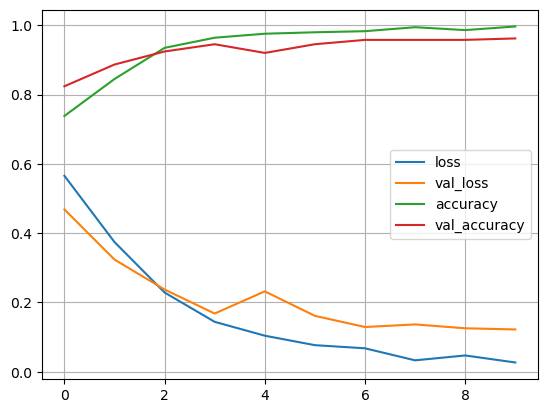

In [18]:
#모델 학습 과정 표시
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [19]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 154ms/step


array([[0.9893112 ],
       [0.02232002],
       [0.98960567]], dtype=float32)

In [20]:
#모델 생성 - SimpleRNN
from keras.layers import LSTM
model = Sequential()
# Embedding(입력사이즈,출력사이즈)
model.add(Embedding(len(word_to_index)+1, 32))
model.add(LSTM(32)) # output size 32
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
#모델 학습
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 3s 47ms/step - loss: 0.6320 - accuracy: 0.7207 - val_loss: 0.5050 - val_accuracy: 0.8494
Epoch 2/10
15/15 [==============================] - 0s 11ms/step - loss: 0.4012 - accuracy: 0.8849 - val_loss: 0.3345 - val_accuracy: 0.8996
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.2729 - accuracy: 0.9132 - val_loss: 0.2410 - val_accuracy: 0.9372
Epoch 4/10
15/15 [==============================] - 0s 10ms/step - loss: 0.1794 - accuracy: 0.9498 - val_loss: 0.1641 - val_accuracy: 0.9623
Epoch 5/10
15/15 [==============================] - 0s 13ms/step - loss: 0.1207 - accuracy: 0.9686 - val_loss: 0.1677 - val_accuracy: 0.9456
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 0.9780 - val_loss: 0.1020 - val_accuracy: 0.9707
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0658 - accuracy: 0.9874 - val_loss: 0.1421 - val_accuracy: 0.9665
Epoch 8/10
15

In [22]:
#모델평가
model.evaluate(X_test, y_test, verbose=0)

[0.12323370575904846, 0.9698996543884277]

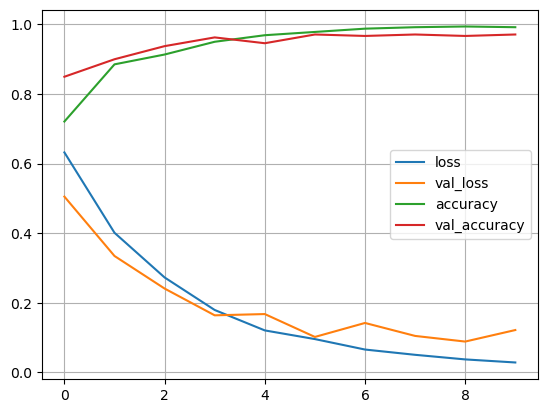

In [23]:
#모델 학습 과정 표시
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [24]:
model.predict(X_test[:3])

1/1 [==============================] - 0s 318ms/step


array([[0.98986393],
       [0.04493082],
       [0.99446774]], dtype=float32)

In [25]:
#인공신경망
model = Sequential()
model.add(Dense(64, input_shape=(77,),  activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                4992      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,161
Trainable params: 8,161
Non-trainable params: 0
_________________________________________________________________


In [26]:
#모델 학습
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15/15 [==============================] - 1s 23ms/step - loss: 46.7795 - accuracy: 0.5356 - val_loss: 31.5295 - val_accuracy: 0.5314
Epoch 2/10
15/15 [==============================] - 0s 10ms/step - loss: 19.5562 - accuracy: 0.6245 - val_loss: 23.3663 - val_accuracy: 0.5774
Epoch 3/10
15/15 [==============================] - 0s 7ms/step - loss: 13.3028 - accuracy: 0.6642 - val_loss: 18.3568 - val_accuracy: 0.6067
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 8.7452 - accuracy: 0.6904 - val_loss: 19.0573 - val_accuracy: 0.5732
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 6.6831 - accuracy: 0.7165 - val_loss: 16.8645 - val_accuracy: 0.6444
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 4.8423 - accuracy: 0.7531 - val_loss: 15.6067 - val_accuracy: 0.6318
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 3.6500 - accuracy: 0.7824 - val_loss: 15.0782 - val_accuracy: 0.6360
Epoch 8/

In [27]:
#모델평가
model.evaluate(X_test, y_test, verbose=0)

[4.404843330383301, 0.6354514956474304]

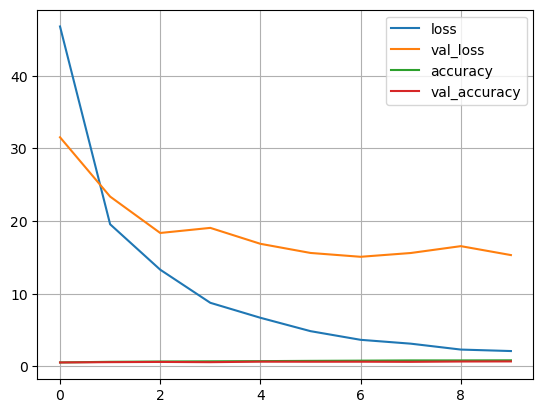

In [28]:
#모델 학습 과정 표시
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()